In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob

from matplotlib.pyplot import imshow

In [20]:
# Functions Dump
def K_means(image, k=3, max_iter=100):
    # Reshape the image to a 2D array of pixels
    pixel_values = image.reshape((-1, 1))
    pixel_values = np.float32(pixel_values)

    # Define criteria and apply kmeans
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, max_iter, 0.2)
    _, labels, centers = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    # Convert back to uint8
    centers = np.uint8(centers)
    segmented_image = centers[labels.flatten()]
    segmented_image = segmented_image.reshape(image.shape)

    return segmented_image

def contrast_stretching(image):
    image = np.float32(image)
    min_val = np.min(image)
    max_val = np.max(image)
    stretched_image = (image - min_val) * (255 / (max_val - min_val))
    stretched_image = np.clip(stretched_image, 0, 255).astype(np.uint8)
    return stretched_image


In [21]:
# generating Histogram plots
def calculate_histogram(directory_path, folder_name, image_name):
    image_path = f"{directory_path}/{folder_name}/{image_name}"
    img_bgr = cv2.imread(image_path)

    path = f"{directory_path}/{folder_name}/"
    x = glob.glob(f'{directory_path}/{folder_name}/*.jpg')



    h_hist = np.zeros((180, 1), dtype=np.float32)
    s_hist = np.zeros((256, 1), dtype=np.float32)
    v_hist = np.zeros((256, 1), dtype=np.float32)


    for path in x:
        img_bgr = cv2.imread(path)
        hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
        h, s, v = cv2.split(hsv)
        h_hist += cv2.calcHist([h], [0], None, [180], [0, 180])
        s_hist += cv2.calcHist([s], [0], None, [256], [0, 256])
        v_hist += cv2.calcHist([v], [0], None, [256], [0, 256])

    if len(x) > 0:
        h_hist /= len(x)
        s_hist /= len(x)
        v_hist /= len(x)

    # Plot results
    plt.figure(figsize=(12, 6))

    plt.subplot(2, 2, 1)
    plt.axis('off')
    plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
    plt.title("Sample Image")

    plt.subplot(2, 2, 2)
    plt.plot(h_hist, color='magenta')
    plt.title("Average Hue Histogram")

    plt.subplot(2, 2, 3)
    plt.plot(s_hist, color='green')
    plt.title("Average Saturation Histogram")

    plt.subplot(2, 2, 4)
    plt.plot(v_hist, color='gray')
    plt.title("Average Value Histogram")

    plt.tight_layout()
    plt.show()

    return h_hist, s_hist, v_hist

# Getting Thresholding range
def thresh_values2(histogram, threshold, n_peaks=20):
    filter_hue = np.arange(180)[threshold:]
    filter_hue_val = histogram[threshold:].ravel()

    hue_peaks = np.argsort(filter_hue_val)[::-1]
    top_peaks = filter_hue[hue_peaks[:n_peaks]]
    top_freqs = filter_hue_val[hue_peaks[:n_peaks]]

    top_peaks = np.sort(top_peaks)
    top_freqs = np.sort(top_freqs)

    return top_peaks, top_freqs

def thresh_values(histogram, threshold=0, n_peaks=20):
    """
    Finds the top `n_peaks` values in a histogram after applying a `threshold` index.
    Returns the original bin indices (not relative ones).

    Parameters:
    - histogram: np.ndarray of shape (N, 1)
    - threshold: minimum bin index to consider
    - n_peaks: number of top peaks to return

    Returns:
    - top_peaks: array of bin indices
    - top_freqs: corresponding frequencies
    """
    histogram = histogram.ravel()  # Flatten to 1D

    if threshold >= len(histogram):
        raise ValueError(f"Threshold {threshold} is out of bounds for histogram of size {len(histogram)}")

    # Slice the histogram starting from the threshold
    filtered_hist = histogram[threshold:]

    # If histogram is too small, adjust n_peaks
    actual_peaks = min(n_peaks, len(filtered_hist))

    # Get the indices of the highest frequencies
    sorted_indices = np.argsort(filtered_hist)[::-1][:actual_peaks]

    # Adjust indices back to the original histogram scale
    top_peaks = sorted_indices + threshold
    top_freqs = histogram[top_peaks]

    return np.sort(top_peaks), np.sort(top_freqs)


def calculate_histogram_single(path, print_cond = True):
    image_path = path
    if path.endswith(".jpg"):
        img_bgr = cv2.imread(image_path)
    else:
        img_bgr = path



    h_hist = np.zeros((180, 1), dtype=np.float32)
    s_hist = np.zeros((256, 1), dtype=np.float32)
    v_hist = np.zeros((256, 1), dtype=np.float32)

    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    h_hist += cv2.calcHist([h], [0], None, [180], [0, 180])
    s_hist += cv2.calcHist([s], [0], None, [256], [0, 256])
    v_hist += cv2.calcHist([v], [0], None, [256], [0, 256])


    # Plot results
    if print_cond:
        plt.figure(figsize=(12, 6))
        plt.subplot(2, 2, 1)
        plt.axis('off')
        plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
        plt.title("Sample Image")

        plt.subplot(2, 2, 2)
        plt.plot(h_hist, color='magenta')
        plt.title("Hue Histogram")

        plt.subplot(2, 2, 3)
        plt.plot(s_hist, color='green')
        plt.title("Saturation Histogram")

        plt.subplot(2, 2, 4)
        plt.plot(v_hist, color='gray')
        plt.title("Value Histogram")

        plt.tight_layout()
        plt.show()

    return h_hist, s_hist, v_hist



def get_cell(image_path, threshold_hue = 80, threshold_saturation = 80):
    image_h_hist, image_s_hist, image_v_hist = calculate_histogram_single(image_path)
    top_peaks, top_freqs = thresh_values(hue_h_hist, threshold_hue)
    top_peaks_sat, top_freqs_sat = thresh_values(hue_s_hist, threshold_saturation)

    # printing the histogram peaks
    print("Top Hues >", thresh_hue, ":", top_peaks)
    print("Top Hue Frequencies:", top_freqs)
    print("Top Hue Saturation Values:", top_freqs_sat)
    print("Top Hue Values:", top_peaks)

    img_bgr = cv2.imread(image_path)
    hsv_img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV) # important to convert to HSV else the mask won't work
    height,width = img_bgr.shape[:2]
    mask2 = np.zeros((height,width), dtype= np.uint8)

    center_x,center_y = int(width//2), int(height//2)
    radius = min(center_x,center_y) - 100
    cv2.circle(mask2, (center_x, center_y),radius,255 , thickness=-1)
    hsv_img = cv2.bitwise_and(hsv_img, hsv_img, mask=mask2)
    # Segmentation ranges
    upper_target_hue = top_peaks[-1] + 20
    lower_target_hue = top_peaks[0] - 20

    # Clamp to valid HSV hue range
    lower_target_hue = max(0, lower_target_hue)
    upper_target_hue = min(179, upper_target_hue)

    lowerbound = np.array([lower_target_hue, 80, 80])
    upperbound = np.array([upper_target_hue, 255, 255])

    # Apply threshold
    mask = cv2.inRange(hsv_img, lowerbound, upperbound)
    result = cv2.bitwise_and(img_bgr, img_bgr, mask=mask)

    return img_bgr, mask, result




In [22]:
# Segmentation using k-means clustering
img = cv2.imread(r'./wbc_data/Train/Basophil/Basophil_2.jpg', cv2.COLOR_BGR2HSV)
img = contrast_stretching(img)
img2 = K_means(img, 2, 50)
cv2.imshow('Original', img)
cv2.imshow('Segmented', img2)
cv2.waitKey(0)
cv2.destroyAllWindows()




Basophil

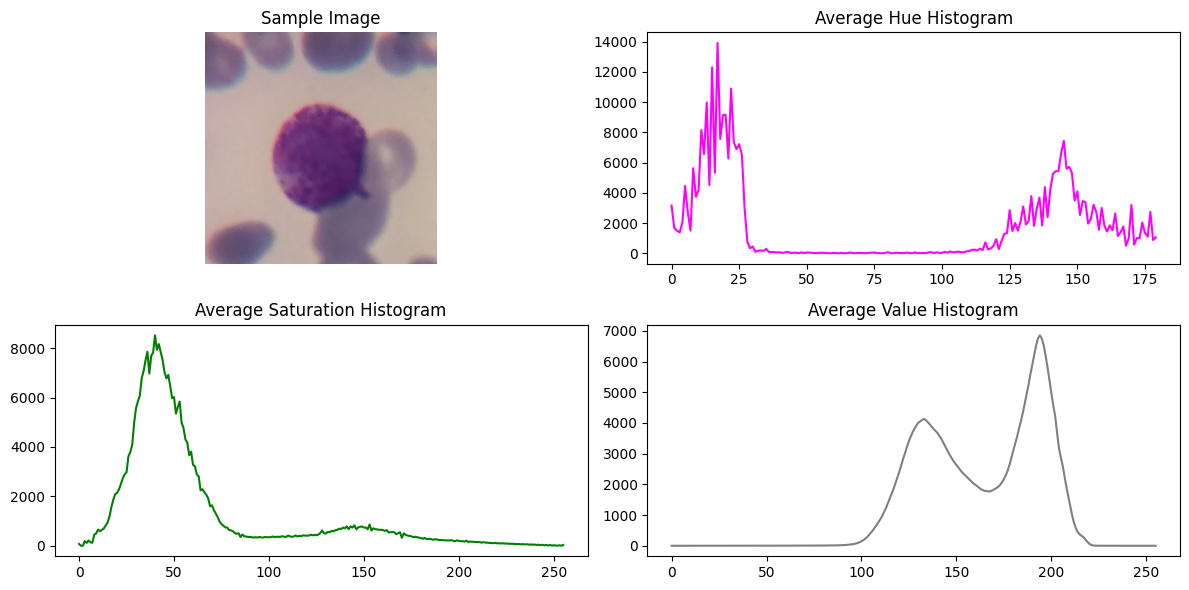

Top Hues > 100 : [130 133 136 138 140 141 142 143 144 145 146 147 148 149 150 152 153 156
 159 170]
Top Hue Frequencies: [3001.78 3095.8  3196.75 3214.22 3387.68 3455.99 3490.16 3683.55 3786.28
 4100.38 4213.03 4381.95 5264.33 5318.29 5428.93 5443.04 5595.31 5730.06
 6613.67 7441.41]
Top Hue Saturation Values: [665.87 666.14 666.72 667.13 669.03 677.2  693.21 701.39 707.36 735.57
 737.26 738.17 740.46 743.86 767.32 781.9  784.89 785.58 827.72 861.57]
Top Hue Values: [130 133 136 138 140 141 142 143 144 145 146 147 148 149 150 152 153 156
 159 170]


In [23]:
[hue_h_hist, hue_s_hist, hue_v_hist] = calculate_histogram('./wbc_data/Train/', 'Basophil', 'Basophil_7.jpg')

thresh_hue = 100
top_peaks, top_freqs = thresh_values(hue_h_hist, thresh_hue)
thresh_hue_s = 80
top_peaks_sat, top_freqs_sat = thresh_values(hue_s_hist, thresh_hue_s)
# Plotting the histogram
print("Top Hues >", thresh_hue, ":", top_peaks)
print("Top Hue Frequencies:", top_freqs)
print("Top Hue Saturation Values:", top_freqs_sat)
print("Top Hue Values:", top_peaks)

# Correct way to read and convert to HSV
img_bgr = cv2.imread('./wbc_data/Train/Basophil/Basophil_2.jpg')
hsv_img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV) # important to convert to HSV else the mask won't work

height,width = img_bgr.shape[:2]
mask2 = np.zeros((height,width), dtype= np.uint8)

center_x,center_y = int(width//2), int(height//2)
radius = min(center_x,center_y) - 140
cv2.circle(mask2, (center_x, center_y),radius,255 , thickness=-1)
hsv_img = cv2.bitwise_and(hsv_img, hsv_img, mask=mask2)


# Segmentation ranges
upper_target_hue = top_peaks[-1] + 10
lower_target_hue = top_peaks[0] - 10

# Clamp to valid HSV hue range
lower_target_hue = max(0, lower_target_hue)
upper_target_hue = min(179, upper_target_hue)

lowerbound = np.array([lower_target_hue, 80, 80])
upperbound = np.array([upper_target_hue, 255, 255])

# Apply threshold
mask = cv2.inRange(hsv_img, lowerbound, upperbound)
result = cv2.bitwise_and(img_bgr, img_bgr, mask=mask)

# Show result
cv2.imshow('Original (BGR)', img_bgr)
cv2.imshow('Mask', mask)
cv2.imshow('Segmented Output', result)
cv2.waitKey(0)
cv2.destroyAllWindows()


Eosinophil

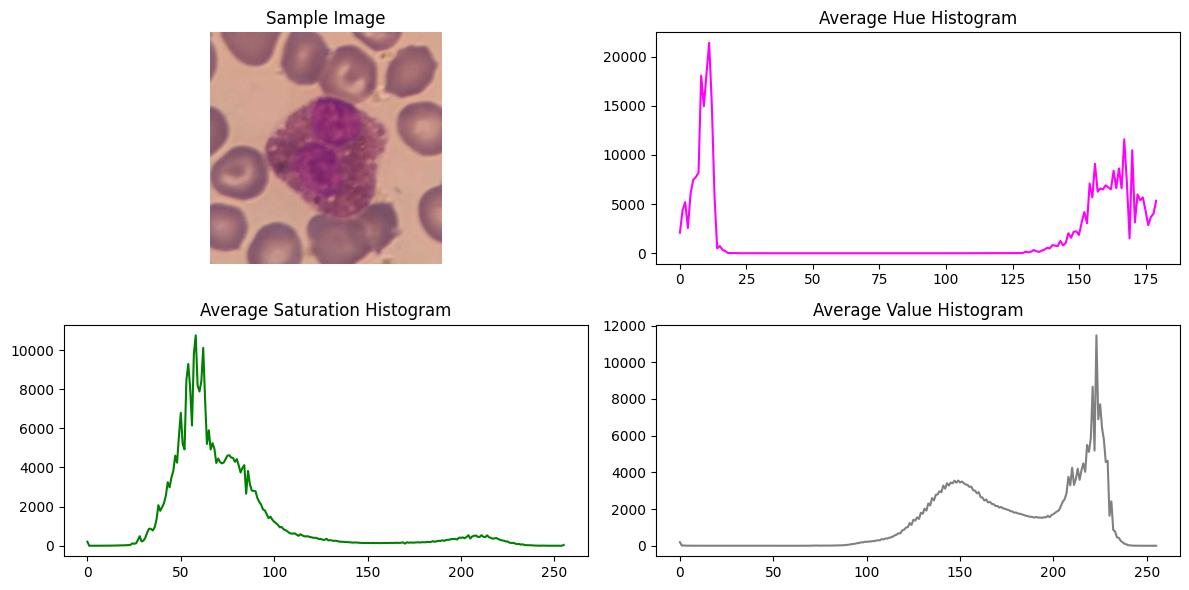

Top Hues > 100 : [154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 170 172 173
 174 179]
Top Hue Frequencies: [ 5339.1   5385.48  5675.76  5684.96  5981.35  6257.01  6494.31  6503.45
  6583.84  6609.91  6612.04  6696.05  6909.84  7090.52  7126.57  8394.63
  8628.06  9104.02 10480.51 11587.82]
Top Hue Saturation Values: [1336.14 1410.96 1485.39 1608.5  1805.99 1854.7  2103.24 2237.77 2443.05
 2659.36 2786.06 2808.03 2819.96 3148.86 3743.8  3821.66 3978.9  4107.65
 4120.4  4427.  ]
Top Hue Values: [154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 170 172 173
 174 179]


In [24]:
[hue_h_hist, hue_s_hist, hue_v_hist] = calculate_histogram('./wbc_data/Train/', 'Eosinophil', 'Eosinophil_7.jpg')

thresh_hue = 100
top_peaks, top_freqs = thresh_values(hue_h_hist, thresh_hue)
thresh_hue_s = 80
top_peaks_sat, top_freqs_sat = thresh_values(hue_s_hist, thresh_hue_s)
# Plotting the histogram
print("Top Hues >", thresh_hue, ":", top_peaks)
print("Top Hue Frequencies:", top_freqs)
print("Top Hue Saturation Values:", top_freqs_sat)
print("Top Hue Values:", top_peaks)

# Correct way to read and convert to HSV
img_bgr = cv2.imread(r'wbc_data/Train/Eosinophil/Eosinophil_7.jpg')
hsv_img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV) # important to convert to HSV else the mask won't work
height,width = img_bgr.shape[:2]
mask2 = np.zeros((height,width), dtype= np.uint8)

center_x,center_y = int(width//2), int(height//2)
radius = min(center_x,center_y) - 140
cv2.circle(mask2, (center_x, center_y),radius,255 , thickness=-1)
hsv_img = cv2.bitwise_and(hsv_img, hsv_img, mask=mask2)
# Segmentation ranges
upper_target_hue = top_peaks[-1] + 10
lower_target_hue = top_peaks[0] - 10

# Clamp to valid HSV hue range
lower_target_hue = max(0, lower_target_hue)
upper_target_hue = min(179, upper_target_hue)

lowerbound = np.array([lower_target_hue, 70, 70])
upperbound = np.array([upper_target_hue, 255, 255])

# Apply threshold
mask = cv2.inRange(hsv_img, lowerbound, upperbound)
result = cv2.bitwise_and(img_bgr, img_bgr, mask=mask)



# Show result
cv2.imshow('Original (BGR)', img_bgr)
cv2.imshow('Mask', mask)
cv2.imshow('Segmented Output', result)
cv2.waitKey(0)
cv2.destroyAllWindows()

Lymphocytes


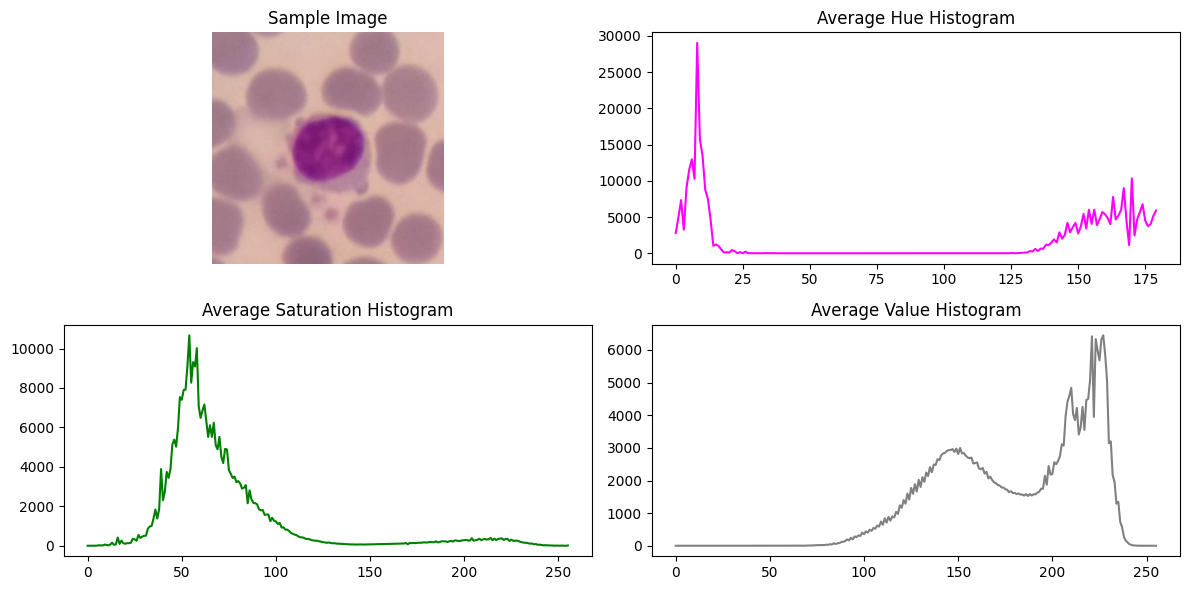

Top Hues > 100 : [152 154 156 158 159 160 161 163 164 165 166 167 168 170 172 173 174 175
 178 179]
Top Hue Frequencies: [ 4497.9   4514.46  4685.68  4697.51  4701.22  4865.58  5134.47  5193.71
  5395.34  5439.29  5690.57  5690.99  5900.28  5987.87  6012.14  6013.56
  6774.29  7775.46  8989.76 10333.15]
Top Hue Saturation Values: [1241.77 1264.45 1414.23 1567.76 1581.19 1584.74 1794.88 1811.72 1852.83
 2101.14 2152.94 2155.83 2171.41 2355.8  2809.87 2895.97 2941.2  3079.38
 3160.48 3277.5 ]
Top Hue Values: [152 154 156 158 159 160 161 163 164 165 166 167 168 170 172 173 174 175
 178 179]


In [25]:
[hue_h_hist, hue_s_hist, hue_v_hist] = calculate_histogram('./wbc_data/Train/', 'Lymphocyte', 'Lymphocyte.jpg')

thresh_hue = 100
top_peaks, top_freqs = thresh_values(hue_h_hist, thresh_hue)
thresh_hue_s = 80
top_peaks_sat, top_freqs_sat = thresh_values(hue_s_hist, thresh_hue_s)
# outputting the peaks for visualisation
print("Top Hues >", thresh_hue, ":", top_peaks)
print("Top Hue Frequencies:", top_freqs)
print("Top Hue Saturation Values:", top_freqs_sat)
print("Top Hue Values:", top_peaks)

# Correct way to read and convert to HSV
img_bgr = cv2.imread(r'wbc_data/Train/Lymphocyte/Lymphocyte_11.jpg')
hsv_img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV) # important to convert to HSV else the mask won't work
height,width = img_bgr.shape[:2]
mask2 = np.zeros((height,width), dtype= np.uint8)

center_x,center_y = int(width//2), int(height//2)
radius = min(center_x,center_y) - 140
cv2.circle(mask2, (center_x, center_y),radius,255 , thickness=-1)
hsv_img = cv2.bitwise_and(hsv_img, hsv_img, mask=mask2)
# Segmentation ranges
upper_target_hue = top_peaks[-1] + 10
lower_target_hue = top_peaks[0] - 10

# Clamp to valid HSV hue range
lower_target_hue = max(0, lower_target_hue)
upper_target_hue = min(179, upper_target_hue)

lowerbound = np.array([lower_target_hue, 70, 70])
upperbound = np.array([upper_target_hue, 255, 255])

# Apply threshold
mask = cv2.inRange(hsv_img, lowerbound, upperbound)
result = cv2.bitwise_and(img_bgr, img_bgr, mask=mask)



# Show result
cv2.imshow('Original (BGR)', img_bgr)
cv2.imshow('Mask', mask)
cv2.imshow('Segmented Output', result)
cv2.waitKey(0)
cv2.destroyAllWindows()

Monocytes


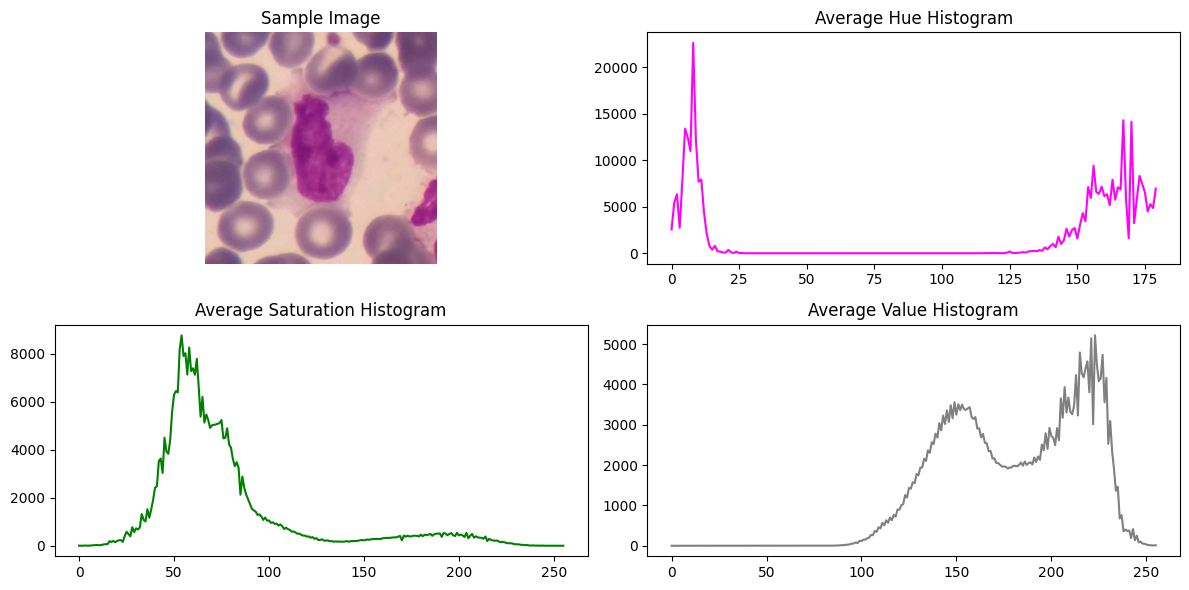

Top Hues > 100 : [154 155 156 157 158 159 160 161 163 164 165 166 167 168 170 172 173 174
 175 179]
Top Hue Frequencies: [ 5749.63  5838.94  5848.36  5953.81  6137.64  6339.42  6390.68  6544.82
  6593.7   6865.23  6951.81  7090.32  7117.53  7160.51  7443.28  7902.04
  8326.91  9417.11 14140.86 14309.4 ]
Top Hue Saturation Values: [1055.49 1075.67 1175.38 1218.75 1285.5  1307.46 1423.39 1475.07 1544.29
 1742.83 1937.88 2126.51 2138.19 2417.3  2883.51 3251.2  3318.61 3483.85
 3618.49 4089.38]
Top Hue Values: [154 155 156 157 158 159 160 161 163 164 165 166 167 168 170 172 173 174
 175 179]


In [26]:
[hue_h_hist, hue_s_hist, hue_v_hist] = calculate_histogram('./wbc_data/Train/', 'Monocyte', 'Monocyte_4.jpg')

thresh_hue = 100
top_peaks, top_freqs = thresh_values(hue_h_hist, thresh_hue)
thresh_hue_s = 80
top_peaks_sat, top_freqs_sat = thresh_values(hue_s_hist, thresh_hue_s)
# Plotting the histogram
print("Top Hues >", thresh_hue, ":", top_peaks)
print("Top Hue Frequencies:", top_freqs)
print("Top Hue Saturation Values:", top_freqs_sat)
print("Top Hue Values:", top_peaks)

# Correct way to read and convert to HSV
img_bgr = cv2.imread(r'wbc_data/Train/Monocyte/Monocyte_10.jpg')
hsv_img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV) # important to convert to HSV else the mask won't work
height,width = img_bgr.shape[:2]
mask2 = np.zeros((height,width), dtype= np.uint8)

center_x,center_y = int(width//2), int(height//2)
radius = min(center_x,center_y) - 140
cv2.circle(mask2, (center_x, center_y),radius,255 , thickness=-1)
hsv_img = cv2.bitwise_and(hsv_img, hsv_img, mask=mask2)
# Segmentation ranges
upper_target_hue = top_peaks[-1] + 10
lower_target_hue = top_peaks[0] - 10

# Clamp to valid HSV hue range
lower_target_hue = max(0, lower_target_hue)
upper_target_hue = min(179, upper_target_hue)

lowerbound = np.array([lower_target_hue, 70, 70])
upperbound = np.array([upper_target_hue, 255, 255])

# Apply threshold
mask = cv2.inRange(hsv_img, lowerbound, upperbound)
result = cv2.bitwise_and(img_bgr, img_bgr, mask=mask)



# Show result
cv2.imshow('Original (BGR)', img_bgr)
cv2.imshow('Mask', mask)
cv2.imshow('Segmented Output', result)
cv2.waitKey(0)
cv2.destroyAllWindows()

Neutrophils


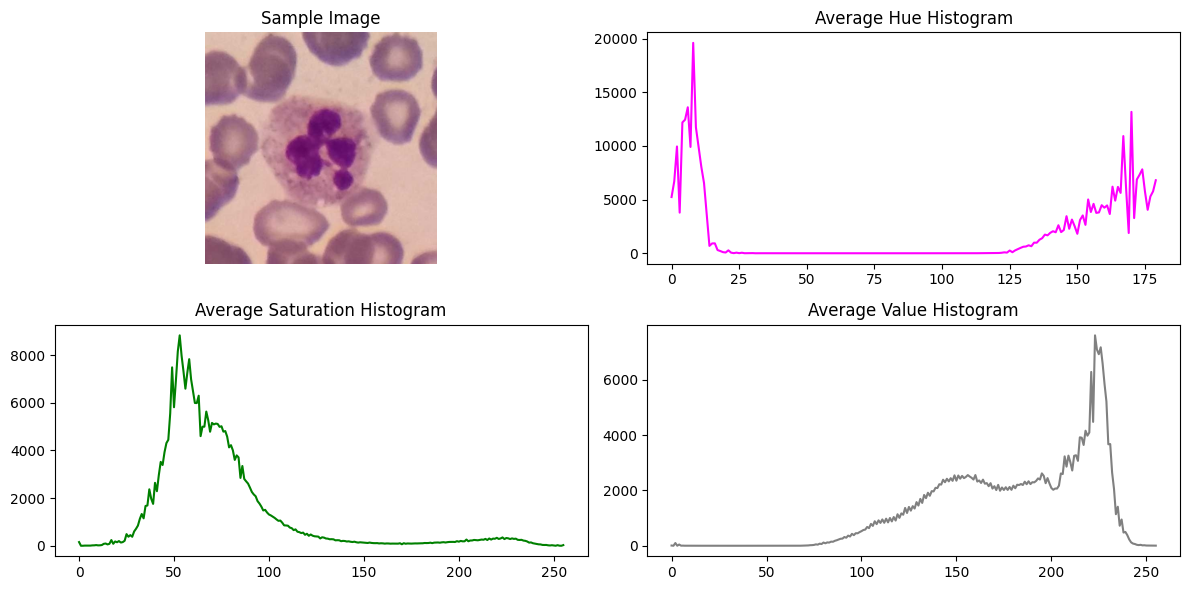

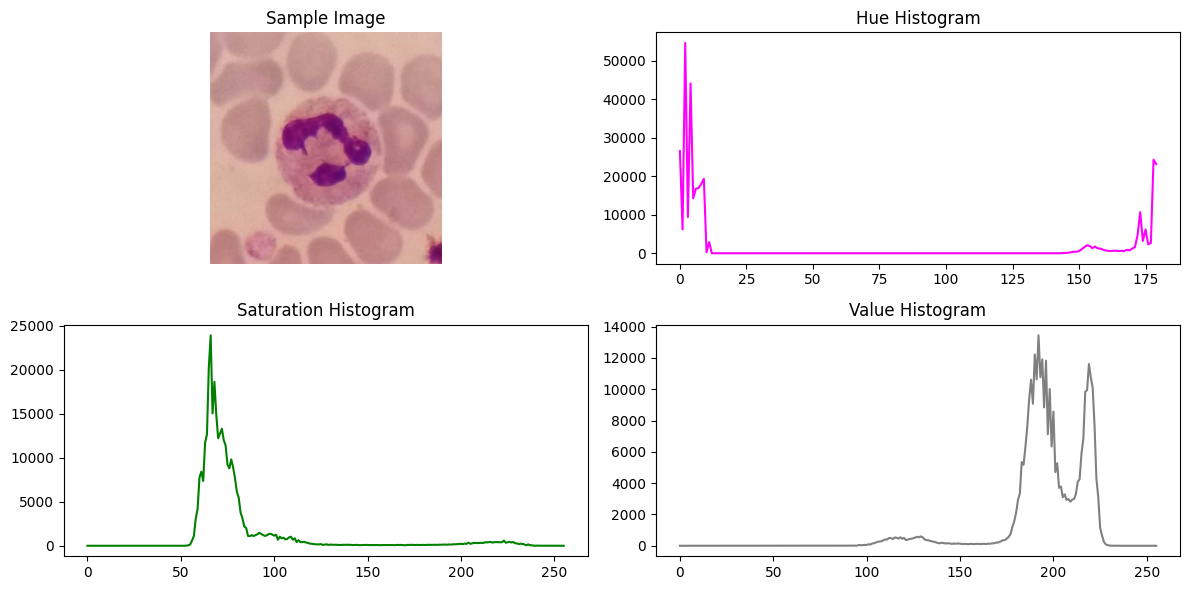

Top Hues > 100 : [154 156 159 160 161 163 164 165 166 167 168 170 172 173 174 175 176 177
 178 179]
Top Hue Frequencies: [ 4047.55  4248.54  4457.55  4478.72  4606.01  4903.84  5012.94  5293.21
  5625.03  5753.05  5773.65  6149.61  6184.5   6204.57  6805.48  6877.36
  7315.57  7820.91 10922.54 13177.43]
Top Hue Saturation Values: [1395.19 1481.67 1506.79 1642.81 1771.26 1872.61 2076.05 2152.97 2257.15
 2439.38 2608.57 2701.06 2802.07 2846.33 3345.96 3601.73 3705.55 3791.35
 4003.19 4220.34]
Top Hue Values: [154 156 159 160 161 163 164 165 166 167 168 170 172 173 174 175 176 177
 178 179]


In [27]:
[hue_h_hist, hue_s_hist, hue_v_hist] = calculate_histogram('./wbc_data/Train/', 'Neutrophil', 'Neutrophil.jpg')

path = r'./wbc_data/Train/Neutrophil/Neutrophil_11.jpg'
thresh_hue = 100
thresh_hue_s = 80
img_bgr , mask, result = get_cell(path, thresh_hue, thresh_hue_s)

# Show result
cv2.imshow('Original (BGR)', img_bgr)
cv2.imshow('Mask', mask)
cv2.imshow('Segmented Output', result)
cv2.waitKey(0)
cv2.destroyAllWindows()





In [51]:
# Functions to spearate cytoplasm and neucleus
def get_nucleus(image_path, threshold_hue = 100, threshold_saturation = 80):
    image_h_hist, image_s_hist, image_v_hist = calculate_histogram_single(image_path, False)
    top_peaks, top_freqs = thresh_values(image_h_hist, threshold_hue,3)
    top_peaks_sat, top_freqs_sat = thresh_values(image_s_hist, threshold_saturation, 3)

    # printing the histogram peaks
    # print("Top Hues >", thresh_hue, ":", top_peaks)
    # print("Top Hue Frequencies:", top_freqs)
    # print("Top Hue Saturation Values:", top_freqs_sat)
    # print("Top Hue Values:", top_peaks)

    img_bgr = cv2.imread(image_path)
    hsv_img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV) # important to convert to HSV else the mask won't work
    height,width = img_bgr.shape[:2]
    mask2 = np.zeros((height,width), dtype= np.uint8)

    center_x,center_y = int(width//2), int(height//2)
    radius = min(center_x,center_y) - 100
    cv2.circle(mask2, (center_x, center_y),radius,255 , thickness=-1)
    hsv_img = cv2.bitwise_and(hsv_img, hsv_img, mask=mask2)

    upper_target_hue = top_peaks[-1] + 5
    lower_target_hue = top_peaks[0] - 25

    # Clamp to valid HSV hue range
    lower_target_hue = max(0, lower_target_hue)
    upper_target_hue = min(179, upper_target_hue)

    lowerbound = np.array([lower_target_hue, 100, 100])
    upperbound = np.array([upper_target_hue, 255, 255])

    # Apply threshold
    neucleus_mask = cv2.inRange(hsv_img, lowerbound, upperbound)
    neeucleus_result = cv2.bitwise_and(img_bgr, img_bgr, mask=neucleus_mask)


    return img_bgr, neucleus_mask, neeucleus_result

def get_cytoplasm(image_path, threshold_hue = 150, threshold_saturation = 80):
    image_h_hist, image_s_hist, image_v_hist = calculate_histogram_single(image_path, False)
    top_peaks, top_freqs = thresh_values(image_h_hist, threshold_hue,3)
    top_peaks_sat, top_freqs_sat = thresh_values(image_s_hist, threshold_saturation, 3)

    # printing the histogram peaks
    # print("Top Hues >", thresh_hue, ":", top_peaks)
    # print("Top Hue Frequencies:", top_freqs)
    # print("Top Hue Saturation Values:", top_freqs_sat)
    # print("Top Hue Values:", top_peaks)

    img_bgr = cv2.imread(image_path)
    hsv_img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV) # important to convert to HSV else the mask won't work
    height,width = img_bgr.shape[:2]
    mask2 = np.zeros((height,width), dtype= np.uint8)

    center_x,center_y = int(width//2), int(height//2)
    radius = min(center_x,center_y) - 100
    cv2.circle(mask2, (center_x, center_y),radius,255 , thickness=-1)
    hsv_img = cv2.bitwise_and(hsv_img, hsv_img, mask=mask2)
    # Segmentation ranges
    upper_target_hue = top_peaks[-1] + 25
    lower_target_hue = top_peaks[0] + 7

    # Clamp to valid HSV hue range
    lower_target_hue = max(0, lower_target_hue)
    upper_target_hue = min(179, upper_target_hue)

    lowerbound = np.array([lower_target_hue, 80, 80])
    upperbound = np.array([upper_target_hue, 255, 255])

    # Apply threshold
    cytoplasm_mask = cv2.inRange(hsv_img, lowerbound, upperbound)
    cytoplasm_result = cv2.bitwise_and(img_bgr, img_bgr, mask=cytoplasm_mask)

    return img_bgr, cytoplasm_mask, cytoplasm_result

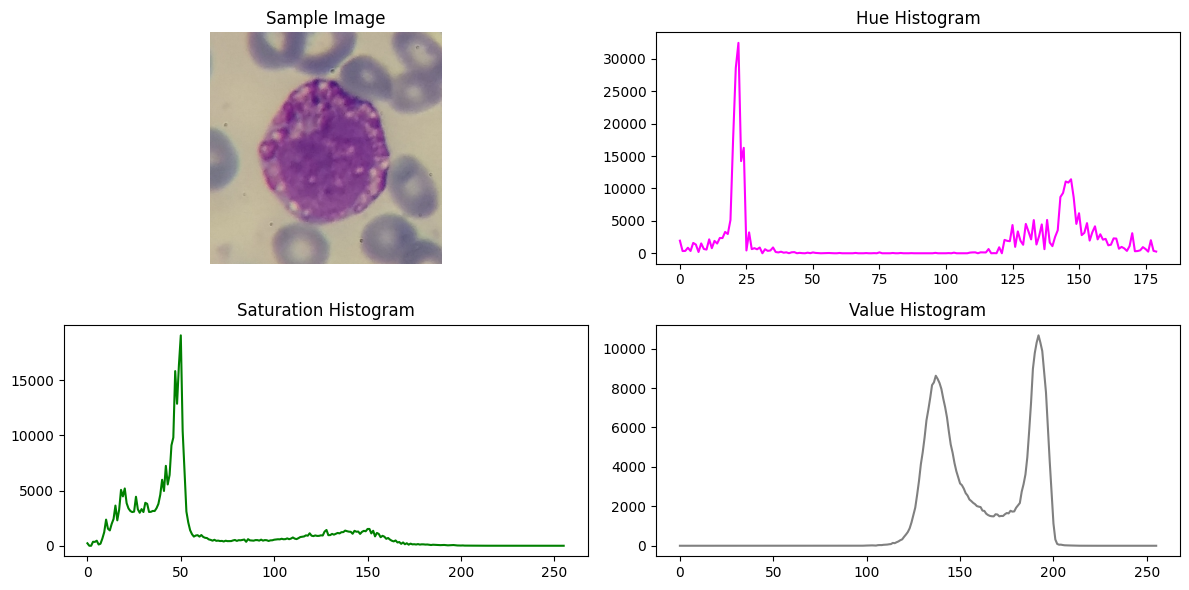

Top Hues > 100 : [154 156 159 160 161 163 164 165 166 167 168 170 172 173 174 175 176 177
 178 179]
Top Hue Frequencies: [ 4047.55  4248.54  4457.55  4478.72  4606.01  4903.84  5012.94  5293.21
  5625.03  5753.05  5773.65  6149.61  6184.5   6204.57  6805.48  6877.36
  7315.57  7820.91 10922.54 13177.43]
Top Hue Saturation Values: [1395.19 1481.67 1506.79 1642.81 1771.26 1872.61 2076.05 2152.97 2257.15
 2439.38 2608.57 2701.06 2802.07 2846.33 3345.96 3601.73 3705.55 3791.35
 4003.19 4220.34]
Top Hue Values: [154 156 159 160 161 163 164 165 166 167 168 170 172 173 174 175 176 177
 178 179]


In [29]:


path = r'./wbc_data/Train/Basophil/Basophil_13.jpg'
thresh_hue = 100
thresh_hue_s = 80

img_bgr, mask, result = get_cell(path, thresh_hue, thresh_hue_s)

# original, mask_neucleus, result_neucleus = get_nucleaus(path)

cv2.imshow('Original (BGR)', img_bgr)
cv2.imshow('Mask', mask)
cv2.imshow('Segmented Output', result)
cv2.waitKey(0)
cv2.destroyAllWindows()

original, mask_neucleus, result_neucleus = get_cytoplasm(path, thresh_hue,thresh_hue_s)

cv2.imshow('Original (BGR)', original)
cv2.imshow('Mask', mask_neucleus)
cv2.imshow('Segmented Output', result_neucleus)
cv2.waitKey(0)
cv2.destroyAllWindows()

original, mask_neucleus, result_neucleus = get_nucleus(path, thresh_hue,thresh_hue_s)

cv2.imshow('Original (BGR)', original)
cv2.imshow('Mask', mask_neucleus)
cv2.imshow('Segmented Output', result_neucleus)
cv2.waitKey(0)
cv2.destroyAllWindows()

Getting The Nucleus and Cytoplasm Ratios

In [57]:
import os

def Ratio_Nucleus_Cytoplasm(image_path, threshold_hue = 100, threshold_saturation = 80):
    original, mask_neucleus, result_neucleus = get_nucleus(image_path, threshold_hue,threshold_saturation)
    original, mask_cytoplasm, result_cytoplasm = get_cytoplasm(image_path, threshold_hue,threshold_saturation)
    # cv2.imshow('cytoplasm', mask_cytoplasm)
    # cv2.imshow('nucleus', mask_neucleus)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    # Calculate the area of the nucleus and cytoplasm
    nucleus_area = cv2.countNonZero(mask_neucleus)
    cytoplasm_area = cv2.countNonZero(mask_cytoplasm)

    # Calculate the ratio
    ratio = nucleus_area / ( cytoplasm_area) if (cytoplasm_area) > 0 else 0
    print(f"Nucleus Area: {nucleus_area}, Cytoplasm Area: {cytoplasm_area}, Ratio: {ratio:.2f}")
    return ratio

def Ratio_Nucleus_Cytoplasm_ranges(folder_path, threshold_hue=100, threshold_saturation=80):
    image_paths = glob.glob(f'{folder_path}/*.jpg')
    ratio_list = []

    for path in image_paths:
        try:
            original, mask_nucleus, result_nucleus = get_nucleus(path, threshold_hue, threshold_saturation)
            original, mask_cytoplasm, result_cytoplasm = get_cytoplasm(path, threshold_hue, threshold_saturation)

            nucleus_area = cv2.countNonZero(mask_nucleus)
            cytoplasm_area = cv2.countNonZero(mask_cytoplasm)

            total =  cytoplasm_area
            ratio = nucleus_area / total if total > 0 else 0

            image_name = os.path.basename(path)
            ratio_list.append((image_name, ratio))

        except Exception as e:
            print(f"Error processing {path}: {e}")
            continue

    return ratio_list

def plot_ranges(ratios):
    image_names, ratio_values = zip(*ratios)

    plt.figure(figsize=(12, 5))
    plt.scatter(range(len(ratio_values)), ratio_values, color='blue', label='Nucleus/Cytoplasm Ratio')
    plt.xlabel("Image Index")
    plt.ylabel("Nucleus Ratio")
    plt.title("Nucleus to (Nucleus + Cytoplasm) Area Ratio Across Images")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def summarize_ratios(ratio_list, label):
    values = [r[1] for r in ratio_list]
    mean = np.mean(values)
    std = np.std(values)
    min_val = np.min(values)
    max_val = np.max(values)

    print(f"{label} Ratios Summary:")
    print(f"  Mean: {mean:.3f}")
    print(f"  Std: {std:.3f}")
    print(f"  Min: {min_val:.3f}")
    print(f"  Max: {max_val:.3f}\n")

    return mean, std, min_val, max_val

def filter_outliers_iqr(ratio_list, k=1.5):
    # Unzip names and ratio values
    names, vals = zip(*ratio_list)
    vals = np.array(vals, dtype=float)

    # Compute Q1, Q3 and IQR
    q1, q3 = np.percentile(vals, [25, 75])
    iqr   = q3 - q1

    # Define “fences”
    lower_fence = q1 - k * iqr
    upper_fence = q3 + k * iqr

    # Select only those within the fences
    mask = (vals >= lower_fence) & (vals <= upper_fence)
    filtered = [(names[i], vals[i]) for i in range(len(vals)) if mask[i]]

    print(f"IQR filtering kept {len(filtered)}/{len(vals)} samples (fences: {lower_fence:.2f}–{upper_fence:.2f})")
    return filtered

def histogram_skewness(hist):
    """
    Compute skewness from a histogram (1D array of bin counts).
    Assumes bins represent 0..len(hist)-1
    """
    hist = hist.ravel().astype(float)
    total = hist.sum()
    if total == 0:
        return 0.0

    x = np.arange(len(hist))
    mean = (hist * x).sum() / total
    var = (hist * (x - mean)**2).sum() / total
    std = np.sqrt(var)

    if std == 0:
        return 0.0

    skewness = (hist * (x - mean)**3).sum() / (total * std**3)
    return skewness

def histogram_skewness_partial(hist, start_bin=110):
    """
    Compute skewness for histogram values starting from a specific bin index.
    """
    hist = hist.ravel().astype(float)
    if start_bin >= len(hist):
        raise ValueError("Start bin is outside histogram range.")

    # Slice histogram and create matching bin indices
    partial_hist = hist[start_bin:]
    bin_indices = np.arange(start_bin, len(hist))

    total = partial_hist.sum()
    if total == 0:
        return 0.0

    mean = (partial_hist * bin_indices).sum() / total
    var = (partial_hist * (bin_indices - mean)**2).sum() / total
    std = np.sqrt(var)

    if std == 0:
        return 0.0

    skewness = (partial_hist * (bin_indices - mean)**3).sum() / (total * std**3)
    return skewness

In [31]:
sample_cell = r'./wbc_data/Train/Lymphocyte/Lymphocyte_11.jpg'
ratio = Ratio_Nucleus_Cytoplasm(sample_cell, thresh_hue,thresh_hue_s)

# Run function on a folder
ratios_lymphocytes = Ratio_Nucleus_Cytoplasm_ranges('./wbc_data/Train/Lymphocyte')
ratio_monocytes = Ratio_Nucleus_Cytoplasm_ranges('./wbc_data/Train/Monocyte')

ratios_basophils = Ratio_Nucleus_Cytoplasm_ranges('./wbc_data/Train/Basophil')
ratios_eosinophils = Ratio_Nucleus_Cytoplasm_ranges('./wbc_data/Train/Eosinophil')
ratio_neutrophils = Ratio_Nucleus_Cytoplasm_ranges('./wbc_data/Train/Neutrophil')



# Example usage
summarize_ratios(ratios_lymphocytes, "Lymphocytes")
summarize_ratios(ratio_monocytes, "Monocytes")
summarize_ratios(ratios_basophils, "Basophils")
summarize_ratios(ratios_eosinophils, "Eosinophils")
summarize_ratios(ratio_neutrophils, "Neutrophils")




Nucleus Area: 23334, Cytoplasm Area: 3236, Ratio: 7.21
Lymphocytes Ratios Summary:
  Mean: 5.421
  Std: 15.733
  Min: 0.398
  Max: 116.194

Monocytes Ratios Summary:
  Mean: 11.297
  Std: 66.112
  Min: 0.000
  Max: 664.196

Basophils Ratios Summary:
  Mean: 2.189
  Std: 1.600
  Min: 0.000
  Max: 9.814

Eosinophils Ratios Summary:
  Mean: 2.152
  Std: 5.685
  Min: 0.000
  Max: 56.734

Neutrophils Ratios Summary:
  Mean: 2.108
  Std: 3.977
  Min: 0.000
  Max: 25.372



(np.float64(2.107608475841255),
 np.float64(3.9770574610023712),
 np.float64(0.0),
 np.float64(25.37192474674385))

In [32]:
def plot_all_classes(*labeled_ratios):
    plt.figure(figsize=(12, 6))

    for idx, (label, data) in enumerate(labeled_ratios):
        _, ratios = zip(*data)
        plt.scatter([idx]*len(ratios), ratios, label=label)

    plt.xticks(range(len(labeled_ratios)), [label for label, _ in labeled_ratios])
    plt.ylabel("Nucleus / Cytoplasm Ratio")
    plt.title("N/C Ratio Distribution by WBC Type")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


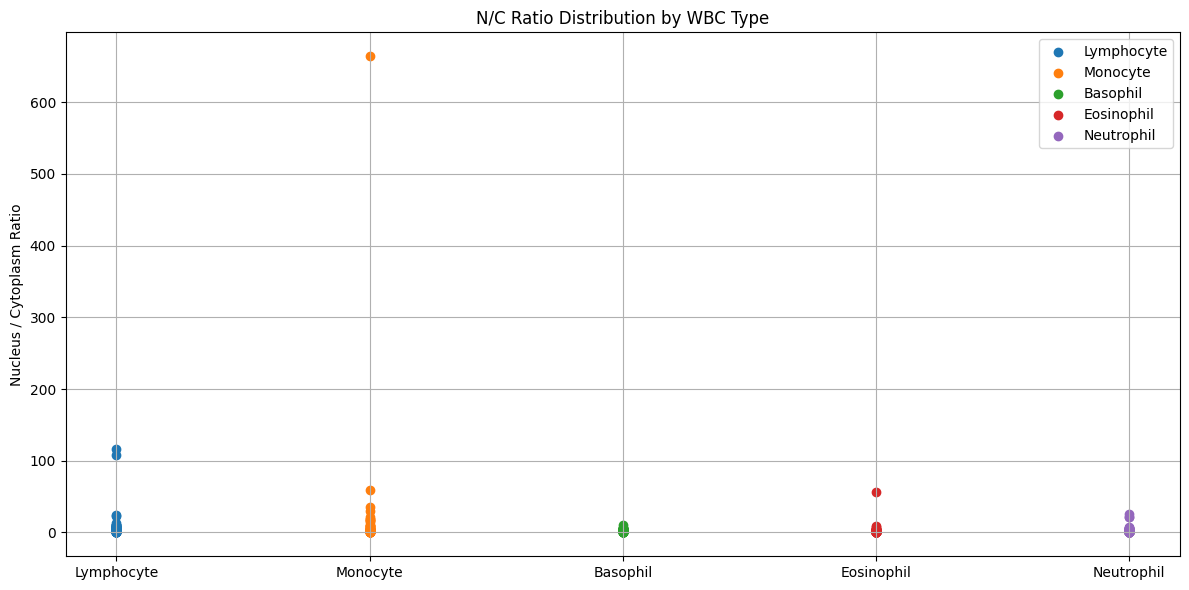

In [33]:
plot_all_classes(
    ("Lymphocyte", ratios_lymphocytes),
    ("Monocyte", ratio_monocytes),
    ("Basophil", ratios_basophils),
    ("Eosinophil", ratios_eosinophils),
    ("Neutrophil", ratio_neutrophils)
)


In [34]:
sample_cell = r'./wbc_data/Train/Basophil/Basophil_13.jpg'
img,img2,img3 =  get_cytoplasm(sample_cell)
cv2.imshow("Image", img)
cv2.imshow("Image2", img2)
cv2.imshow("Image3", img3)
cv2.waitKey(0)
cv2.destroyAllWindows()





In [35]:
def get_mean(folder_path, threshold_hue=100, threshold_saturation=80):
    image_paths = glob.glob(f'{folder_path}/*.jpg')
    mean_val = 0

    for path in image_paths:
        try:
            original, mask_nucleus, result_nucleus = get_nucleus(path, threshold_hue, threshold_saturation)

            nucleus_area = cv2.countNonZero(mask_nucleus)


            mean_val += nucleus_area

        except Exception as e:
            print(f"Error processing {path}: {e}")
            continue
    mean_val /= len(image_paths)
    return mean_val

def get_nucleus_area(path):
    original, mask_nucleus, result_nucleus = get_nucleus(path)
    nucleus_area = cv2.countNonZero(mask_nucleus)
    return nucleus_area

In [65]:
# lymphocytes and Basophils mean
mean_val_lymphocytes = get_mean('./wbc_data/Train/Lymphocyte')
mean_val_basophils = get_mean('./wbc_data/Train/Basophil')
mean_val_monocytes = get_mean('./wbc_data/Train/Monocyte')
mean_val_neurophils = get_mean('./wbc_data/Train/Neutrophil')
mean_val_eosinophils = get_mean('./wbc_data/Train/Eosinophil')

print(f"mean value lymphocytes: {mean_val_lymphocytes}")
print(f"mean value Basophils: {mean_val_basophils}")
print(f"mean value monocytes: {mean_val_monocytes}")
print(f"mean value neutrophils: {mean_val_neurophils}")
print(f"mean value eosinophils: {mean_val_eosinophils}")


mean value lymphocytes: 21294.5
mean value Basophils: 39751.25
mean value monocytes: 36615.29
mean value neutrophils: 22285.12
mean value eosinophils: 33446.58


In [74]:
def classification(image_path, threshold_hue = 100, threshold_saturation = 80):
    print(get_nucleus_area(image_path))
    # print(get)
    ratio = Ratio_Nucleus_Cytoplasm(image_path, threshold_hue, threshold_saturation)
    if ratio > 3.6:
        if get_nucleus_area(image_path) > 25000:
            return "Basophil"
        else:
            return "Lymphocyte"
    else :
        if get_nucleus_area(image_path) < 23000:
            return "Neutrophils"
        else:
            h_hist, s_hist, v_hist = calculate_histogram_single(image_path, False)
            skewness = histogram_skewness_partial(h_hist, 110)
            if skewness > 0.5:
                return "Eosinophil"
            else:

                return "Monocyte"




In [67]:
classification('./wbc_data/Train/Basophil/Basophil_14.jpg')



39851
Nucleus Area: 39851, Cytoplasm Area: 12178, Ratio: 3.27


'Basophil'

In [71]:
def accuracy_classification(folder_path, class_name , threshold_hue=100, threshold_saturation=80):
    image_paths = glob.glob(f'{folder_path}/*.jpg')
    correct_count = 0
    total_count = len(image_paths)

    for path in image_paths:
        try:
            predicted_class = classification(path, threshold_hue, threshold_saturation)
            actual_class = class_name
            print(predicted_class, actual_class)
            if predicted_class == actual_class:
                correct_count += 1

        except Exception as e:
            print(f"Error processing {path}: {e}")
            continue


    accuracy = (correct_count / total_count) * 100 if total_count > 0 else 0
    print(f"Accuracy: {accuracy:.2f}%")
    return accuracy

In [77]:
monocyte_accuracy = accuracy_classification('./wbc_data/Train/Monocyte', "Monocyte")
lymphocyte_accuracy = accuracy_classification('./wbc_data/Train/Lymphocyte', "Lymphocyte")
basophil_accuracy = accuracy_classification('./wbc_data/Train/Basophil', "Basophil")
eosinophil_accuracy = accuracy_classification('./wbc_data/Train/Eosinophil', "Eosinophil")
neutrophil_accuracy = accuracy_classification('./wbc_data/Train/Neutrophil', "Neutrophil")
print("Monocyte Accuracy: ", monocyte_accuracy)
print("Lymphocyte Accuracy: ", lymphocyte_accuracy)
print("Basophil Accuracy: ", basophil_accuracy)
print("Eosinophil Accuracy: ", eosinophil_accuracy)
print("Neutrophil Accuracy: ", neutrophil_accuracy)

total_accuracy = monocyte_accuracy + lymphocyte_accuracy + basophil_accuracy + eosinophil_accuracy + neutrophil_accuracy
total_accuracy /= 5
print(f"Total Accuracy: {total_accuracy:.2f}%")

35375
Nucleus Area: 35375, Cytoplasm Area: 11328, Ratio: 3.12
Monocyte Monocyte
39783
Nucleus Area: 39783, Cytoplasm Area: 3220, Ratio: 12.35
Basophil Monocyte
35726
Nucleus Area: 35726, Cytoplasm Area: 2895, Ratio: 12.34
Basophil Monocyte
42161
Nucleus Area: 42161, Cytoplasm Area: 297, Ratio: 141.96
Basophil Monocyte
33192
Nucleus Area: 33192, Cytoplasm Area: 38, Ratio: 873.47
Basophil Monocyte
34911
Nucleus Area: 34911, Cytoplasm Area: 7450, Ratio: 4.69
Basophil Monocyte
48927
Nucleus Area: 48927, Cytoplasm Area: 19141, Ratio: 2.56
Monocyte Monocyte
30553
Nucleus Area: 30553, Cytoplasm Area: 2, Ratio: 15276.50
Basophil Monocyte
47374
Nucleus Area: 47374, Cytoplasm Area: 35694, Ratio: 1.33
Monocyte Monocyte
51649
Nucleus Area: 51649, Cytoplasm Area: 25803, Ratio: 2.00
Eosinophil Monocyte
38643
Nucleus Area: 38643, Cytoplasm Area: 0, Ratio: 0.00
Monocyte Monocyte
43975
Nucleus Area: 43975, Cytoplasm Area: 17532, Ratio: 2.51
Monocyte Monocyte
30957
Nucleus Area: 30957, Cytoplasm Area: 1